# Crime and Weather

Simple question: how does temperature affect crime rates?

Since daily temperature variations are "fairly random," I think there's actually a fairly compelling causal story in this case.

To answer this, we'll use:
* Historical data from the [Weather Underground API](https://www.wunderground.com/weather/api/d/docs?d=data/history).  We will have to get this data piece by piece.  We can get 500 requests per day with the free API -- basically a year's worth.  So we can download one year at a time.  (The more-sophisticated way to do this is to set up a "cron" job on a Mac or Task Scheduler job on Windows.)
  * I have made a "fake API" for 2015, replacing: 
    http://api.wunderground.com/api/MY_API_KEY/history_20150101/q/KMDW.json<br>
    with: https://raw.githubusercontent.com/harris-ippp/lectures/master/09-weather/data/wu/history_20150101/q/KMDW.json    
* Crime APIs and data from:
  * Chicago: https://dev.socrata.com/foundry/data.cityofchicago.org/6zsd-86xi
  * Philadelphia: https://cityofphiladelphia.github.io/carto-api-explorer/#incidents_part1_part2
  * Phoenix: https://www.phoenix.gov/OpenDataFiles/Crime%20Stats.csv
  * Dallas: https://dev.socrata.com/foundry/www.dallasopendata.com/qqc2-eivj
  * San Francisco: https://dev.socrata.com/foundry/data.sfgov.org/cuks-n6tp
  
  Except Phoenix, these APIs all have SQL-like interfaces.  We can just the data that we need, through the databases.

Here are our standard imports: we'll want pandas, requests, datetime, statsmodels, seaborn.

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt
import numpy as np

import requests, json

import pandas as pd
import seaborn as sns
sns.set_style("whitegrid", rc={'axes.linewidth': 2.5})
sns.set_context('notebook', font_scale=1.45, rc={"lines.linewidth": 3, "figure.figsize" : (7, 3)})

import pytz
import datetime

from urllib.parse import quote

from scipy import stats
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.regression.mixed_linear_model as sm_mlm

from time import sleep

## Weather in Chicago
We are well-acquainted with the correlated variation in crime and weather, in Chicago.  But how do we get that data?  We'll have to loop through days (and airports).  Since we can only get one year at a time, we'll have to cache all of this.

To do this, we'll use the [`datetime`](https://docs.python.org/3.5/library/datetime.html) package: `date` and `timedelta`.

```
date = datetime.date(2015, 1, 1)
```

and 

```
date + datetime.timedelta(d)
```

The "make-believe" endpoint is:
```
https://raw.githubusercontent.com/harris-ippp/lectures/master/09-weather/data/wu/history_{}/q/K{}.json
```

Let's begin by examining a single json response

In [2]:
wu = "https://raw.githubusercontent.com/harris-ippp/lectures/master/09-weather/data/wu/history_{}/q/K{}.json"

date = datetime.date(2015, 1, 1)

addr = wu.format(str(date).replace("-", ""), "MDW")
j = requests.get(wu.format(str(date + datetime.timedelta(1)).replace("-", ""), "MDW")).json()

* Extract (write to file) from this response the time, precipitation, and temperature for each observation.  Assume that the negative precipitation is balderdash.
* Then do this for every day in 2015 (the only year for which the "pretend endpoint" is set up).

In [3]:
station = "MDW"
nyd = datetime.date(2015, 1, 1)

for d in range(10):
    
    date = str(nyd + datetime.timedelta(d))
    
    addr = wu.format(date.replace("-", ""), station)
    j = requests.get(addr).json()
    
    with open(station + "/" + date + ".csv", "w") as out:
        for obs in j["history"]["observations"]:
            
            time = "{year}-{mon}-{mday}T{hour}:{min}:00Z".format(**obs["utcdate"])
            t = obs["tempi"]
            precip = "0" if float(obs["precipi"]) < 0 else obs["precipi"]
            out.write(",".join([time, t, precip]) + "\n")
            
    print(date)
    sleep(1)


2015-01-01
2015-01-02
2015-01-03
2015-01-04
2015-01-05
2015-01-06
2015-01-07
2015-01-08
2015-01-09
2015-01-10


When this is all done, `cat` them all together:

```
cat MDW/*csv > MDW.csv
```

Since we wanted more data, I've done this for 15 years of data, and stashed this in `data/MDW.csv`.  Let's import that data.  We'll have to do `index_col`, `names`, and `parse_dates`:

In [4]:
weather_mdw = pd.read_csv("data/MDW.csv", index_col = "Date", parse_dates = ["Date"],
                          names = ["Date", "Temperature [F]", "Precipitation [In]"])

We saw this last week as well, but we'll need to "localize" the time from UTC to US/Central:

In [5]:
weather_mdw.set_index(weather_mdw.index.tz_localize(pytz.UTC).tz_convert(pytz.timezone('US/Central')), inplace = True)

Plot this and make sure everything looks alright -- apply any necessary masks.

In [6]:
weather_mdw = weather_mdw[weather_mdw["Temperature [F]"] > -500]

Finally, resample at the one-day level (`df.resamples("1D").mean()`).

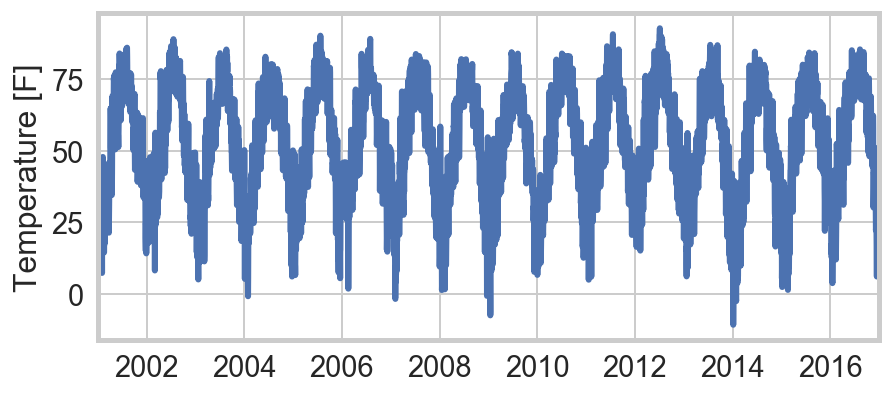

In [7]:
weather_mdw = weather_mdw[["Temperature [F]", "Precipitation [In]"]].resample("1D").mean()
weather_mdw.set_index(weather_mdw.index, inplace = True)
ax = weather_mdw["Temperature [F]"].plot()
ax.set_ylabel("Temperature [F]")
ax.set_xlabel("");

## City Crime Data

### Chicago

You downloaded a big chunk of the city's crime data to do your pandas homework.

We can't do that today -- too much data.  But to start, all we want are the [dates](https://dev.socrata.com/docs/datatypes/floating_timestamp.html#) and the crime counts.

We can get this from the APIs, using SoQL queries (Socrata Query Language ~ SQL): basically, SQL without `FROM` statements.

https://dev.socrata.com/foundry/data.cityofchicago.org/6zsd-86xi

https://dev.socrata.com/docs/queries/

We'll use `urllib.parse.quote` to encode URLs: change spaces to %20, etc.

We'll group by date, and count rows: `Count(*) AS Count`.

Be careful not to "hammer" the API.  With a token you get ~unlimited calls, but without one it's quite restricted.

By default the limit is 1000 rows.  Here, we're asking for daily observations for 14 years, around 5000 rows.

In [8]:
if False:

    soql = "https://data.cityofchicago.org/resource/6zsd-86xi.json?$query="
    soql += quote("SELECT date_trunc_ymd(date) AS Date, count(*) AS Count ")
    soql += quote("WHERE 2002 < year AND year < 2017 ")
    soql += quote("GROUP BY Date LIMIT 10000")

    resp = requests.get(soql).json()

    with open("data/chicago_daily.csv", "w") as out: json.dump(resp, out, indent = 2)
        
else: 
    
    with open("data/chicago_daily.csv") as data: resp = json.load(data)

Now format these data.  Specifically: convert `Date` to a date (`pd.to_datetime(df.Date)`) and `Count` to an `int`.

In [9]:
daily_crimes = pd.DataFrame(resp)
daily_crimes.Date = pd.to_datetime(daily_crimes.Date)
daily_crimes.Count = daily_crimes.Count.astype(int)
daily_crimes.set_index("Date", inplace = True)

Localize the time!!

In [10]:
daily_crimes.set_index(daily_crimes.index.tz_localize(pytz.timezone('US/Central')), inplace = True)

Plot the data.  Make sure you label your axes!

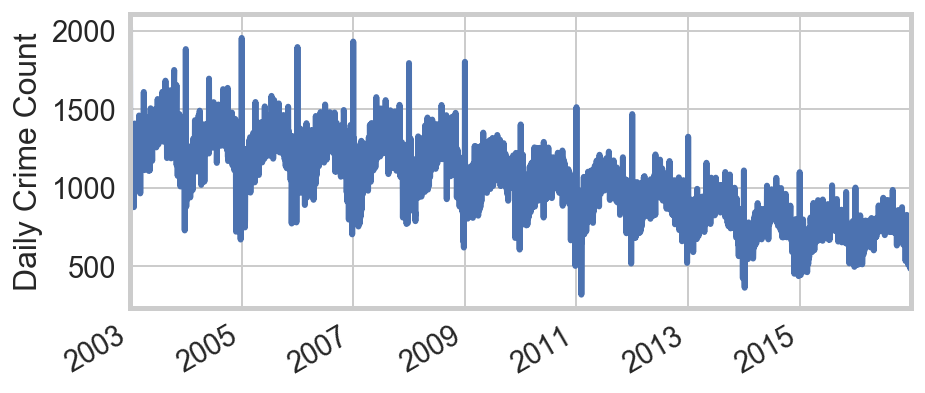

In [11]:
ax = daily_crimes["Count"].plot()
ax.set_xlabel("")
ax.set_ylabel("Daily Crime Count");

To see it a little more clearly, resample to the one-month level: `df.resample("1M").sum()`.

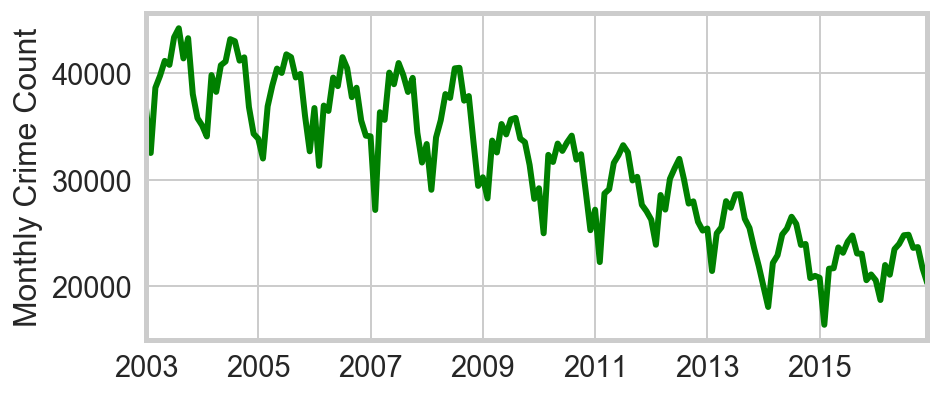

In [12]:
ax = daily_crimes["Count"].resample("1M").sum().plot(c = "g")
ax.set_xlabel("")
ax.set_ylabel("Monthly Crime Count");

We should see a clear seasonal "oscillation" here.  But is this just an efect of longer evening hours?  Or rowdy kids free from school?

### Warm Places: It's Not Sunlight
Loading crime data from San Francisco, Dallas, and Phoenix (grouped at the monthly level) suggests that the temperature variations are actually important: it's not just daylight or the school calendar.

We'll do each of these more or less in passing.

San Francisco: https://dev.socrata.com/foundry/data.sfgov.org/cuks-n6tp

Use a `WHERE` clause to exclue non-criminal incidents.

In [13]:
sf_url =  "https://data.sfgov.org/resource/cuks-n6tp.json?$query="
sf_url += quote("SELECT date_trunc_ym(date) AS Month, count(date) AS Count ")
sf_url += quote("WHERE category!='NON-CRIMINAL' AND date_extract_y(date)<2017 GROUP BY Month")

sf_crime = pd.read_json(sf_url, convert_dates = ["Month"])
sf_crime.set_index("Month", inplace = True)

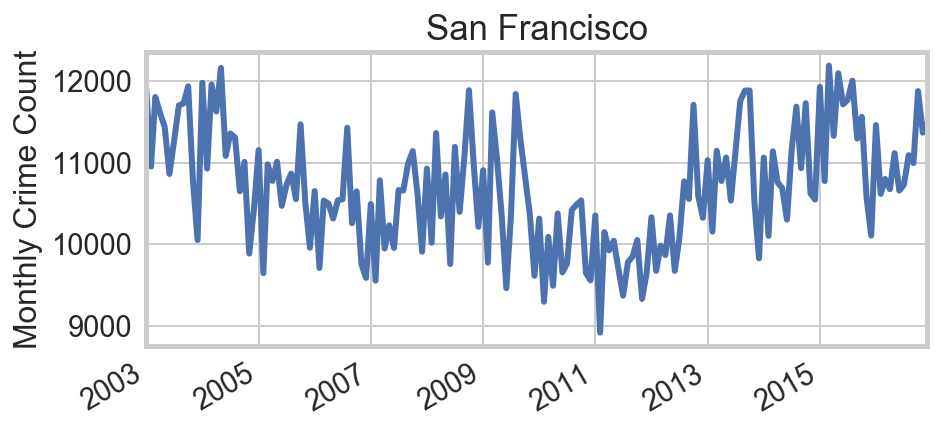

In [14]:
ax = sf_crime["Count"].plot(x = "Month", y = "Count", title = "San Francisco")
ax.set_ylabel("Monthly Crime Count")
ax.set_xlabel("");

No trend here!

For Phoenix, they just supply a file.  Let's download that and load it up.

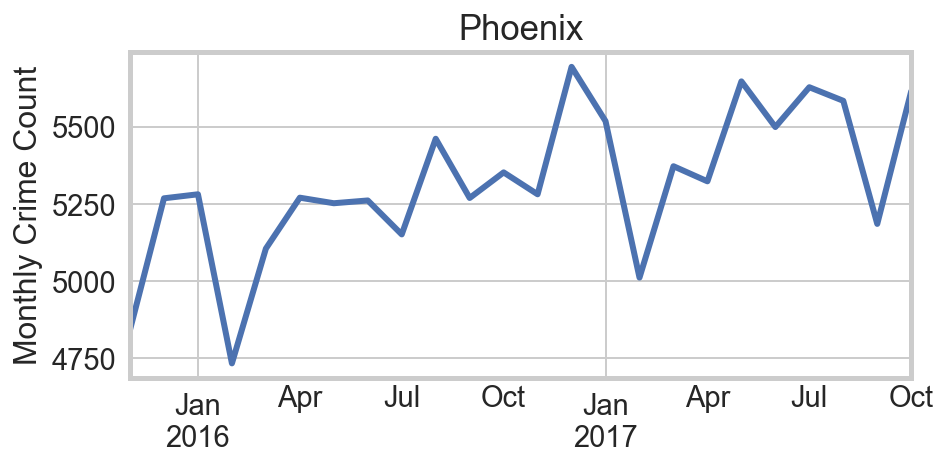

In [15]:
# ! curl https://www.phoenix.gov/OpenDataFiles/Crime%20Stats.csv -o "data/phoenix_az.csv"

phoenix_crime = pd.read_csv("data/phoenix_az.csv",
                            parse_dates = ["OCCURRED ON"], infer_datetime_format = True,
                            index_col = "OCCURRED ON", usecols = ["UCR CRIME CATEGORY", "OCCURRED ON"])

phoenix_crime = phoenix_crime[phoenix_crime.index < datetime.datetime(2017, 11, 1)]
ax = phoenix_crime["UCR CRIME CATEGORY"].resample("1M").count().plot(title = "Phoenix")
ax.set_ylabel("Monthly Crime Count")
ax.set_xlabel("");

And likewise for Dallas -- reject accidents and non-offenses:
```
WHERE offincident NOT LIKE '%NO OFFENSE%' AND offincident NOT LIKE '%ACCIDENT INV%' 
```

In [16]:
dal_url =  "https://www.dallasopendata.com/resource/qqc2-eivj.json?$query="
dal_url += quote("SELECT date_trunc_ym(date1) AS date, count(*) AS count ")
dal_url += quote("WHERE offincident NOT LIKE '%NO OFFENSE%' AND offincident NOT LIKE '%ACCIDENT INV%' ")
dal_url += quote("GROUP BY date ORDER BY date")

dal = pd.read_json(dal_url, convert_dates = ["date"])
dal.set_index("date", inplace = True)

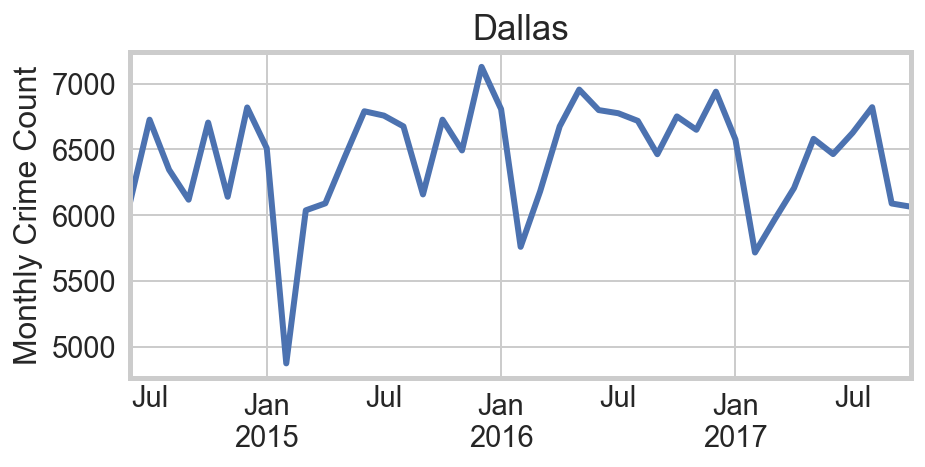

In [17]:
mask = (dal.index >= datetime.datetime(2014, 6, 1)) & \
       (dal.index <  datetime.datetime(2017, 11, 1))

ax = dal.loc[mask, "count"].plot(title = "Dallas")
ax.set_ylabel("Monthly Crime Count")
ax.set_xlabel("")

Phoenix and Dallas do seem to show drops in February -- but of around 10%, instead of the 25-35% drops from Chicago.  

The greatest city in the world also has real seasons.  So let's see what happens there.

Like a real prize fighter, Philadelphia uses genuine SQL (Postgres variety).  The table is `incidents_part1_part2`.

* https://cityofphiladelphia.github.io/carto-api-explorer/#incidents_part1_part2

In [18]:
phl_url =  "https://phl.carto.com/api/v2/sql?q="
phl_url += "SELECT CONCAT(SUBSTRING(dispatch_date FROM 0 FOR 8), '-01') AS date, COUNT(*) AS count "
phl_url += "FROM incidents_part1_part2 GROUP BY date;"

resp = requests.get(phl_url).json()

In [19]:
phl_crime = pd.read_json(json.dumps(resp["rows"]), convert_dates = ["date"])
phl_crime.set_index("date", inplace = True)
phl_crime = phl_crime[phl_crime.index < datetime.datetime(2017, 1, 1)]

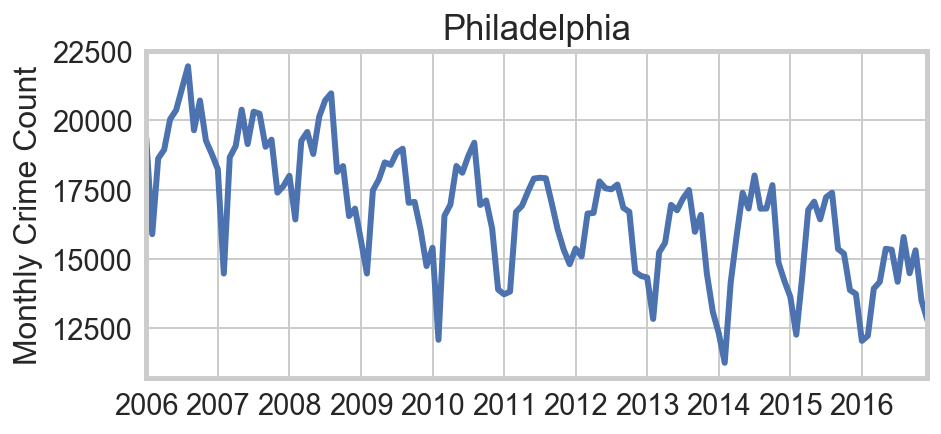

In [20]:
ax = phl_crime["count"].resample("1M").sum().plot(title = "Philadelphia")
ax.set_xlabel("")
ax.set_ylabel("Monthly Crime Count");

Great job, Philly -- those are some collosal seasonal variations in criminality.

### The Question is, what drives the variation?
Is it the absolute temperature only?  Or can the relative temperature (today is a nice day) also affect it?  Let's construct a few measures: use `df.shift(±1)` to get yesterday's or tomorrow's weather.  We can't _just_ use yesterday, since that will have a seasonal variation.

We'll also have to do a `dropna()`, since this won't be defined on the edge days.

In [21]:
# Define "Yesterday [F]" and "Tomorrow [F]"
weather_mdw["Yesterday [F]"] = weather_mdw['Temperature [F]'].shift(1)
weather_mdw["Tomorrow [F]"]  = weather_mdw['Temperature [F]'].shift(-1)

# The shift, using the same measure.
weather_mdw['Daily Diff [F]'] = weather_mdw['Temperature [F]'] - 0.5 * (weather_mdw['Yesterday [F]'] + weather_mdw["Tomorrow [F]"])
weather_mdw['Yesterday Diff [F]'] = weather_mdw['Temperature [F]'] - weather_mdw['Yesterday [F]']

weather_mdw.dropna(inplace = True)

There do not seem to be significant trends in the short-term shift comparisons, by season.

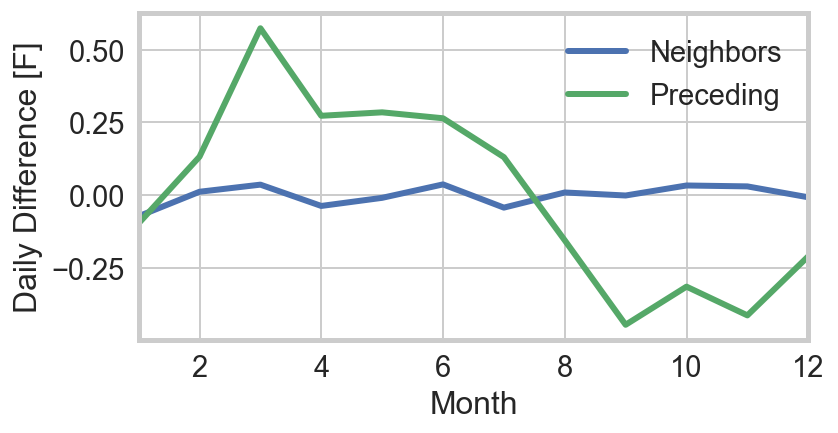

In [22]:
ax = weather_mdw["Daily Diff [F]"].groupby(weather_mdw.index.month).mean().plot(figsize = (6, 3), label = "Neighbors")
ax = weather_mdw['Yesterday Diff [F]'].groupby(weather_mdw.index.month).mean().plot(figsize = (6, 3), label = "Preceding")
ax.set_xlabel("Month");
ax.set_ylabel("Daily Difference [F]");
ax.legend()

Create similar ratios for crime:  We want to be able to look for changes in the daily crime counts, from daily temperature changes.

In [23]:
daily_crimes['Two Week Split [Count]'] = 0.5 * (daily_crimes['Count'].rolling(window = 7, center = False).mean().shift(-7) +
                                                daily_crimes['Count'].rolling(window = 7, center = False).mean().shift(1))

daily_crimes['Two Week Ratio [Count]'] = daily_crimes['Count'] / daily_crimes['Two Week Split [Count]']
daily_crimes.dropna(inplace = True)

Merge the two datasets.  Crime and year variables will be useful, since there are strong trends by year in the Chicago data.

In [24]:
cw = pd.concat([weather_mdw, daily_crimes], axis = 1).dropna()

In [26]:
cw["Month"] = cw.index.month
cw["Year"] = (cw.index - datetime.datetime(2001, 1, 1, 0, 0, tzinfo = pytz.timezone('UTC'))) / datetime.timedelta(days=365.25)
cw["Yint"] = cw.index.year
cw["Day of Week"] = cw.index.dayofweek
cw["YestInt"] = (weather_mdw["Yesterday [F]"]/10.).round(1).astype(int)*10
cw["Precip"] = cw["Precipitation [In]"] > 0

There is very clear tempeature dependence, but also a huge spread.  Most of this is presumably from the secular trend over time.

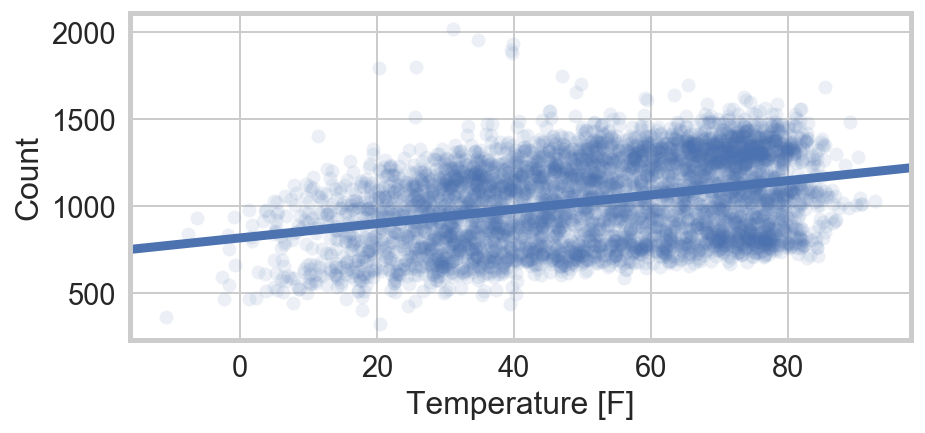

In [27]:
sns.regplot(x = "Temperature [F]", y = "Count", data = cw, scatter_kws = {"alpha" : 0.1});

The coefficient on the temperature is highly significant.

In [28]:
ols = smf.ols(formula = "NC ~ C(Yint) + T + P + C(DoW) + DD",
              data = cw.rename(columns = {"Count" : "NC", 
                                          "Temperature [F]"  : "T", 
                                          "Precip"           : "P", 
                                          "Daily Diff [F]"   : "DD",
                                          "Day of Week"      : "DoW"}))
model = ols.fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     NC   R-squared:                       0.881
Model:                            OLS   Adj. R-squared:                  0.881
Method:                 Least Squares   F-statistic:                     1709.
Date:                Mon, 20 Nov 2017   Prob (F-statistic):               0.00
Time:                        01:41:56   Log-Likelihood:                -29733.
No. Observations:                5099   AIC:                         5.951e+04
Df Residuals:                    5076   BIC:                         5.966e+04
Df Model:                          22                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept        1069.9210      6.046    176.970      0.000    1058.069    1081.773
C(Yint)[T.2004]   -25.7529      6.119     -4.209      0.000     -37.748     -13.758
C(Yint)[T.2005]   -71.9263      6.124    -11.746      0.000     -83.931     -59.921
C(Yint)[T.2006]   -88.9723      6.129    -14.517      0.000    -100.987     -76.957
C(Yint)[T.2007]  -114.9770      6.132    -18.751      0.000    -126.998    -102.956
C(Yint)[T.2008]  -133.7526      6.120    -21.856      0.000    -145.750    -121.755
C(Yint)[T.2009]  -224.0410      6.126    -36.570      0.000    -236.051    -212.031
C(Yint)[T.2010]  -298.1402      6.127    -48.658      0.000    -310.152    -286.128
C(Yint)[T.2011]  -346.0456      6.133    -56.427      0.000    -358.068    -334.023
C(Yint)[T.2012]  -409.7360      6.134    -66.795      0.000    -421.762    -397.710
C(Yint)[T.2013]  -463.0993      6.123    -75.639      0.000    -475.102    -451.097
C(Yint)[T.2014]  -546.2371      6.132    -89.084      0.000    -558.258    -534.216
C(Yint)[T.2015]  -592.4519      6.133    -96.607      0.000    -604.474    -580.429
C(Yint)[T.2016]  -588.9125      6.131    -96.051      0.000    -600.932    -576.893
P[T.True]         -30.1351      2.494    -12.084      0.000     -35.024     -25.246
C(DoW)[T.1]        20.8510      4.331      4.814      0.000      12.360      29.342
C(DoW)[T.2]        31.2277      4.330      7.212      0.000      22.739      39.716
C(DoW)[T.3]        21.3249      4.329      4.926      0.000      12.839      29.811
C(DoW)[T.4]        77.8334      4.334     17.957      0.000      69.336      86.331
C(DoW)[T.5]        17.7599      4.334      4.098      0.000       9.264      26.256
C(DoW)[T.6]       -40.3787      4.330     -9.326      0.000     -48.867     -31.891
T                   4.4557      0.060     73.662      0.000       4.337       4.574
DD                 -0.9297      0.262     -3.548      0.000      -1.443      -0.416
==============================================================================
Omnibus:                     2033.575   Durbin-Watson:                   1.495
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            53043.577
Skew:                           1.329   Prob(JB):                         0.00
Kurtosis:                      18.576   Cond. No.                         806.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

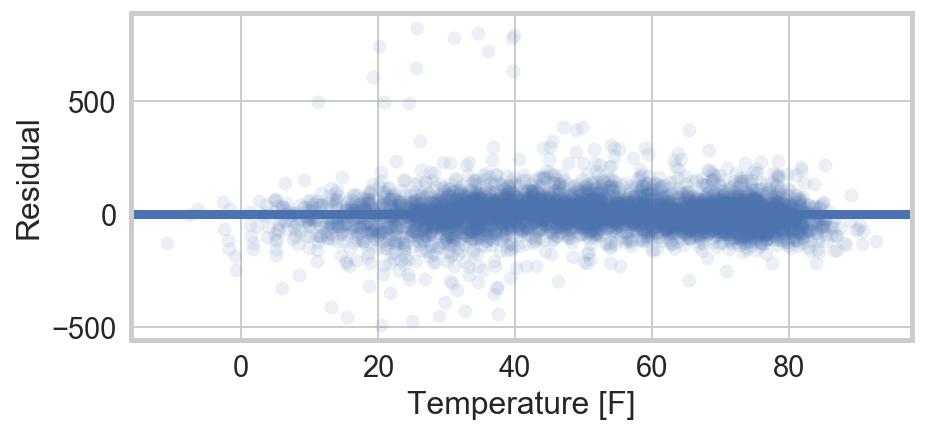

In [29]:
sns.regplot(x = cw["Temperature [F]"], y = pd.Series(model.resid, name = "Residual"), scatter_kws = {"alpha" : 0.1});

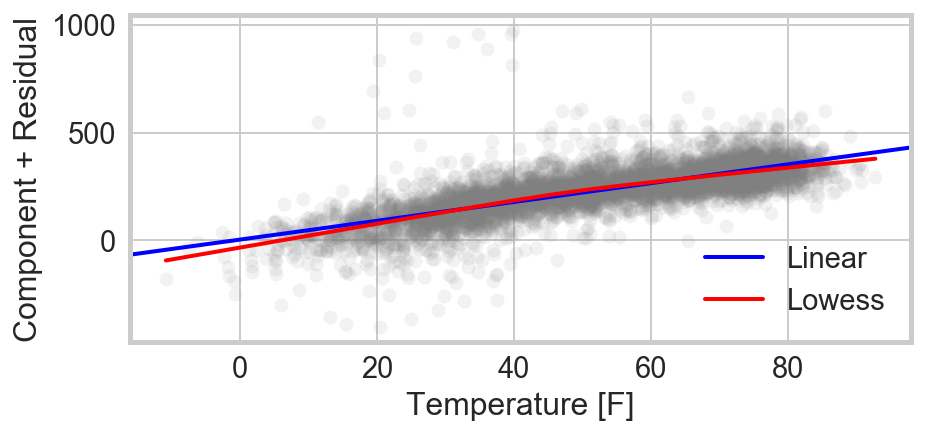

In [30]:
cpr = pd.Series(name = "Component + Residual", data = model.resid + cw["Temperature [F]"] * model.params["T"])
ax = sns.regplot(x = cw["Temperature [F]"], y = cpr, scatter = True, fit_reg = False,
            scatter_kws = {"alpha" : 0.1, "color" : "grey"})
sns.regplot(x = cw["Temperature [F]"], y = cpr, scatter = False, 
            lowess = False, robust = True, label = "Linear",
            scatter_kws = {"alpha" : 0.1, "color" : "grey"}, line_kws = {"color" : "blue", "linewidth" : 2})
sns.regplot(x = cw["Temperature [F]"], y = cpr, scatter = False, 
            lowess = True, label = "Lowess",
            scatter_kws = {"alpha" : 0}, line_kws = {"color" : "red", "linewidth" : 2}, ax = ax);

ax.legend()

There are some pretty striking outliers here -- they're basically all January 1.  We'll come back to this.

In [31]:
cw[model.resid > 400].index

DatetimeIndex(['2003-01-01 06:00:00+00:00', '2004-01-01 06:00:00+00:00',
               '2005-01-01 06:00:00+00:00', '2006-01-01 06:00:00+00:00',
               '2007-01-01 06:00:00+00:00', '2008-01-01 06:00:00+00:00',
               '2009-01-01 06:00:00+00:00', '2010-01-01 06:00:00+00:00',
               '2011-01-01 06:00:00+00:00', '2012-01-01 06:00:00+00:00',
               '2013-01-01 06:00:00+00:00', '2014-01-01 06:00:00+00:00',
               '2015-01-01 06:00:00+00:00'],
              dtype='datetime64[ns, UTC]', name='Date', freq=None)

# Outliers -- January 1

A very natural explanation for outliers is that there is just a coding problem -- or a ton of crimes without valid dates that just get set to the beginning of the year.

There could also be categories of crime -- for instance, financial crimes -- with less-precise timestamps, that are simply set to January.

To start, let's comapre New Year's Day with the rest of January.  We can write queries to do most of the work for us, within the city's SoQL database!

There is one trick here: SoQL doesn't do the automatic bool → int conversion, so it won't do a sum for us of booleans.  We have to "manually" convert it using 

```
sum(case(date_extract_d(date) = 1, 31, true, 0))
```

In [32]:
if False:

    soql = "https://data.cityofchicago.org/resource/6zsd-86xi.json?$query="
    soql += quote("SELECT primary_type AS Offense, count(*) AS NJanuary, ")
    soql += quote("sum(case(date_extract_d(date) = 1, 31, true, 0))/count(*) AS Ratio ")
    soql += quote("WHERE 2002 < year AND year < 2017 AND date_extract_m(date) = 1 ")
    soql += quote("GROUP BY Offense ORDER BY Ratio DESC")

    resp = requests.get(soql).json()

    with open("data/january_crime.json", "w") as out: json.dump(resp, out, indent = 2)
        
else: 
    
    with open("data/january_crime.json") as data: resp = json.load(data)

nyd = pd.DataFrame(resp)
nyd.NJanuary = nyd.NJanuary.astype(int)
nyd.Ratio = nyd.Ratio.astype(float)
nyd = nyd[nyd.NJanuary >= 20]

Just as an alternative, we could have done a ton of this with grep etc.:

In [33]:
# ! cat /media/jsaxon/brobdingnag/data/crime/chicago_il.csv | grep ",01\/01\/20[01][0-9]" | cut -f6 -d, | sort | uniq -c | sort -n | sed "s/^ *\([0-9]*\) /\1,/" > data/new_years_crime.csv
# ! cat /media/jsaxon/brobdingnag/data/crime/chicago_il.csv | grep ",01\/[0-3][0-9]\/20[01][0-9]" | cut -f6 -d, | sort | uniq -c | sort -n| sed "s/^ *\([0-9]*\) /\1,/" > data/january_crime.csv

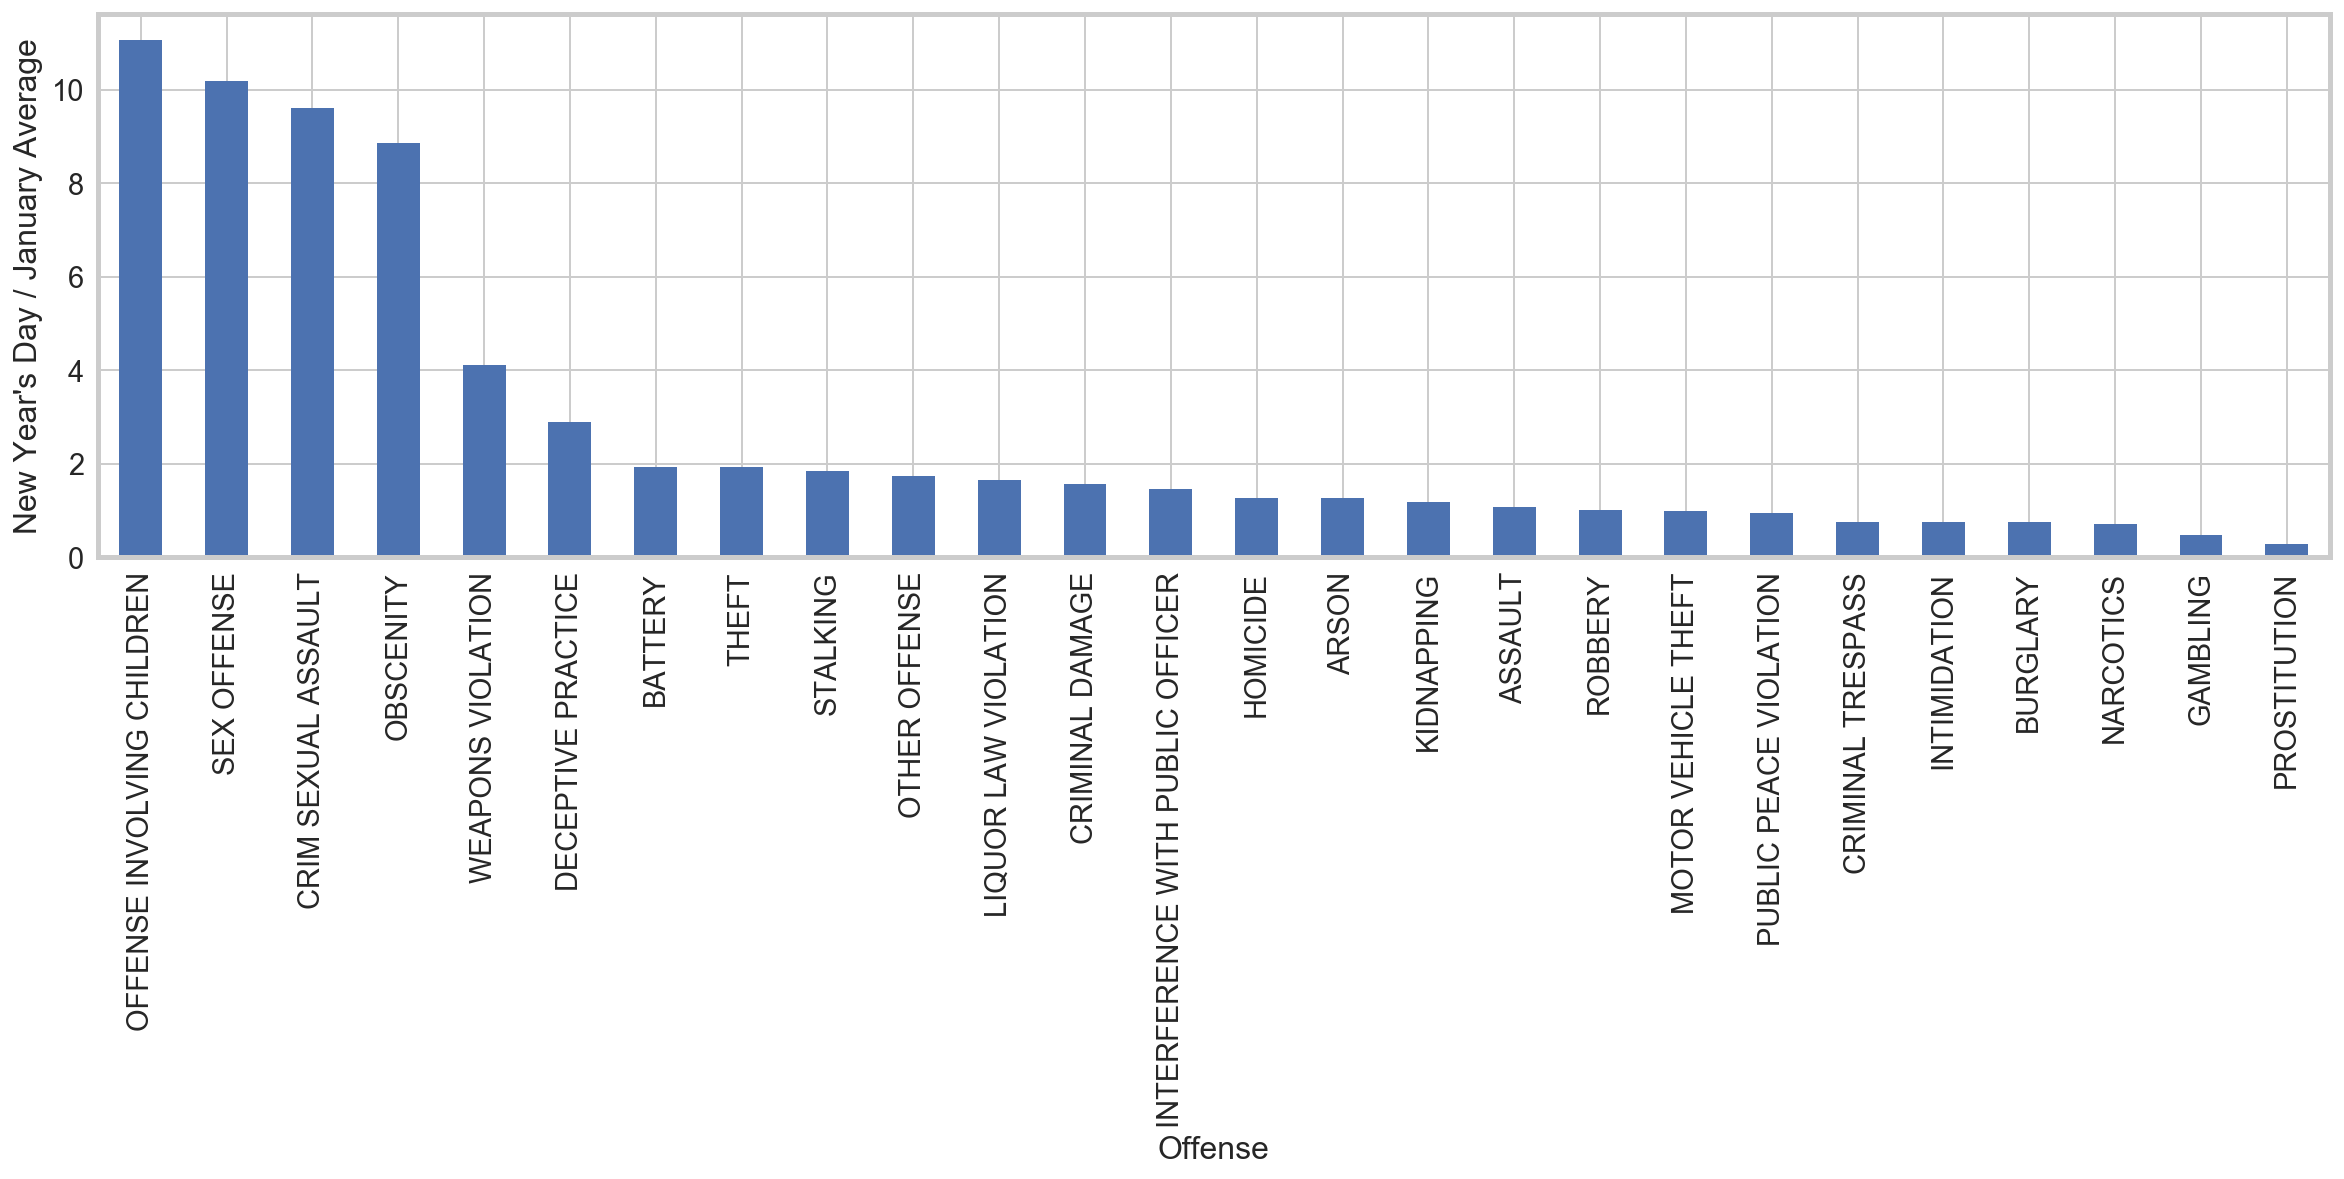

In [34]:
ax = nyd.set_index("Offense")["Ratio"].plot(kind = 'bar', figsize = (20, 5))
ax.set_ylabel("New Year's Day / January Average")

In [35]:
nyd.sort_values(by = "NJanuary", ascending = False).head(10)\
   [["Offense", "NJanuary", "Ratio"]].reset_index(drop = True)

,Offense,NJanuary,Ratio
0,THEFT,83126,1.936614
1,BATTERY,68150,1.942333
2,NARCOTICS,50950,0.719176
3,CRIMINAL DAMAGE,43029,1.561203
4,OTHER OFFENSE,28668,1.749616
5,BURGLARY,23781,0.749548
6,ASSAULT,22001,1.086360
7,MOTOR VEHICLE THEFT,20587,0.995337
8,DECEPTIVE PRACTICE,16549,2.894133
9,ROBBERY,15773,1.014138


OK, well this is not something I wanted to know about New Year's: high crime across the board, but particularly sex crimes and crimes involving children.  Nevertheless, the "overall" excess of crimes comes from the usual heavy hitters -- theft and battery.

# Various Types of Crime

Which types of crimes are most correlated with temperature, after controlling for the large overal drops over time?

As an alternative to the SoQL databases, we could do a ton of this via grep:

In [36]:
# # This is just wildly faster by command line.
# ! cat /media/jsaxon/brobdingnag/data/crime/chicago_il.csv | tail -n +2\
#       | cut -f3,6 -d, \
#       | sed "s/\([01][0-9]\)\/\([0-3][0-9]\)\/\(20[01][0-9]\)/\3\/\1\/\2/" \
#       | sed "s/ [01][0-9]:[0-5][0-9]:[0-5][0-9] [AP]M//" | sort | uniq -c \
#       | sed -e "s/ *//" -e "s/ /,/" \
#       > chicago_crime_types.csv

First make a list of the common types of crime (top 20 occurrences).

In [37]:
chicago_types = pd.read_csv("data/chicago_crime_types.csv", 
                            parse_dates = ["Date"],
                            names = ["Count", "Date", "Type"])

common_crimes = chicago_types.groupby("Type").sum()["Count"].sort_values(ascending = False).head(20).index.tolist()

In [38]:
chicago_types = chicago_types[chicago_types.Type.isin(common_crimes)]
chicago_types["Year"] = chicago_types.Date.dt.year
chicago_types["DoW"] = chicago_types.Date.dt.dayofweek

weather_mdw["Date"] = pd.to_datetime(weather_mdw.index.date)

chicago_types = pd.merge(weather_mdw[["Temperature [F]", "Date"]], chicago_types)

In [39]:
from sklearn import linear_model # could have done: smf.ols, scipy.stats.linregress, 
from scipy import stats

controls = ["Year"]

corr = []
for cr in common_crimes:
    regr = linear_model.LinearRegression()

    df = chicago_types[chicago_types.Type == cr].copy()

    regr.fit(df[controls], df[["Count"]])
    df["resid"] = df[["Count"]] - regr.predict(df[controls])

    r = stats.pearsonr(df["resid"], df["Temperature [F]"])
    corr.append((cr, r[0], r[1]))
    
pd.DataFrame(corr, columns = ["Offense", "R", "p"]).sort_values(by = "R", ascending = False).reset_index(drop = True).head(10)

,Offense,R,p
0,BATTERY,0.623900,0.000000e+00
1,ASSAULT,0.607792,0.000000e+00
2,THEFT,0.551482,0.000000e+00
3,CRIMINAL DAMAGE,0.507817,0.000000e+00
4,GAMBLING,0.424212,1.175745e-186
5,ROBBERY,0.366855,4.311987e-183
6,BURGLARY,0.317854,1.905039e-135
7,PUBLIC PEACE VIOLATION,0.267343,1.128161e-94
8,WEAPONS VIOLATION,0.256463,3.378571e-87
9,SEX OFFENSE,0.187064,3.683990e-44


# Non-Linear Least Squares
Try a kink or a quadratic to find the "best" temperature to mug at.  I'm interested in whether there is an "maximal" temperature for time, and so I will focus on the afternoon, when it might be hot enough to see the turn-over.

In [40]:
from lmfit import minimize, Parameters, report_fit

In [41]:
weather_mdw = pd.read_csv("data/MDW.csv", header = None,
                          index_col = "Date", parse_dates = ["Date"], 
                          names = ["Date", "Temperature [F]", "Precipitation [In]"])

weather_mdw.set_index(weather_mdw.index.tz_localize(pytz.UTC).tz_convert(pytz.timezone('US/Central')), inplace = True)

In [42]:
afternoon_weather = weather_mdw[weather_mdw["Temperature [F]"] > -500 &
                                            (12 <= weather_mdw.index.hour) & (weather_mdw.index.hour < 18)]

afternoon_avg_temp = pd.DataFrame(afternoon_weather["Temperature [F]"].resample("1D").mean())

In [43]:
# This is just wildly faster by command line.
# If need be, we can make it python
# ! cat /media/jsaxon/brobdingnag/data/crime/chicago_il.csv \
#       | cut -f3 -d"," | grep PM | grep " [01][12345]" \
#       | cut -f1 -d " " \
#       | sed "s/\(..\)\/\(..\)\/\(....\)/\3\/\1\/\2/" \
#       | sort | uniq -c | grep -v "[A-Z]" \
#       > chicago_afternoon_crime_counts.csv

In [44]:
afternoon_crimes = pd.read_csv("data/chicago_afternoon_crime_counts.csv", index_col = "Date", parse_dates = True,
                           delim_whitespace = True, names = ["Count", "Date"])

afternoon_crimes.set_index(afternoon_crimes.index.tz_localize(pytz.timezone('US/Central')), inplace = True) 

In [45]:
ct_mdw = pd.concat([afternoon_avg_temp, afternoon_crimes], axis = 1).dropna()
ct_mdw.set_index(ct_mdw.index.tz_convert(pytz.timezone('US/Central')), inplace = True)

In [46]:
ct_mdw["Year"] = (ct_mdw.index - datetime.datetime(2001, 1, 1, 0, 0, tzinfo = pytz.timezone('US/Central'))) / datetime.timedelta(days=365.25)
ct_mdw["Yint"] = ct_mdw.index.year
ct_mdw["DoW"] = ct_mdw.index.dayofweek

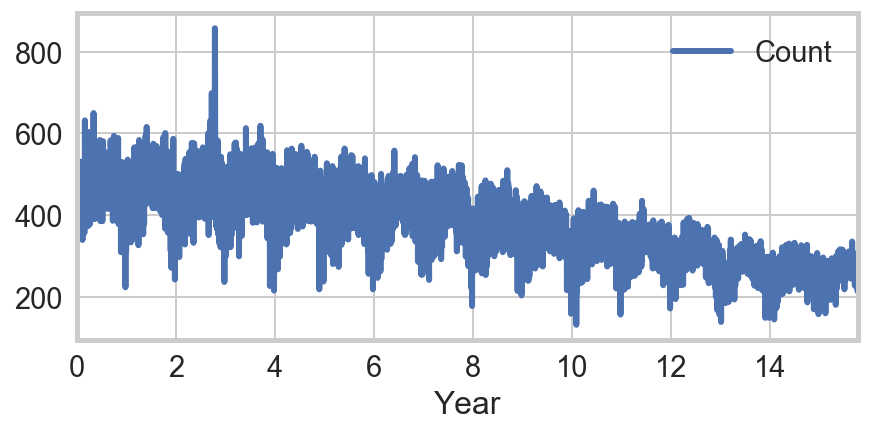

In [47]:
ct_mdw.plot(x = "Year", y = "Count")

In [48]:
ols = smf.ols(formula = "NC ~ Year",
              data = ct_mdw.rename(columns = {"Count" : "NC", 
                                              "Temperature [F]" : "T"}))
model = ols.fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     NC   R-squared:                       0.668
Model:                            OLS   Adj. R-squared:                  0.668
Method:                 Least Squares   F-statistic:                 1.159e+04
Date:                Mon, 20 Nov 2017   Prob (F-statistic):               0.00
Time:                        01:42:32   Log-Likelihood:                -30918.
No. Observations:                5762   AIC:                         6.184e+04
Df Residuals:                    5760   BIC:                         6.185e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    506.7661      1.364    371.544      0.000     504.092     509.440
Year         -16.1179      0.150   -107.645      0.000     -16.411     -15.824
==============================================================================
Omnibus:                      308.728   Durbin-Watson:                   1.109
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              861.892
Skew:                          -0.268   Prob(JB):                    6.96e-188
Kurtosis:                       4.817   Cond. No.                         18.4
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [49]:
ols = smf.ols(formula = "NC ~ Year + T",
              data = ct_mdw.rename(columns = {"Count" : "NC", 
                                              "Temperature [F]" : "T"}))
model = ols.fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     NC   R-squared:                       0.738
Model:                            OLS   Adj. R-squared:                  0.738
Method:                 Least Squares   F-statistic:                     8130.
Date:                Mon, 20 Nov 2017   Prob (F-statistic):               0.00
Time:                        01:42:32   Log-Likelihood:                -30230.
No. Observations:                5762   AIC:                         6.047e+04
Df Residuals:                    5759   BIC:                         6.049e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    444.7505      1.986    223.978      0.000     440.858     448.643
Year         -16.3173      0.133   -122.690      0.000     -16.578     -16.057
T              1.2161      0.031     39.401      0.000       1.156       1.277
==============================================================================
Omnibus:                      335.027   Durbin-Watson:                   1.399
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1415.592
Skew:                           0.055   Prob(JB):                    4.06e-308
Kurtosis:                       5.426   Cond. No.                         185.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

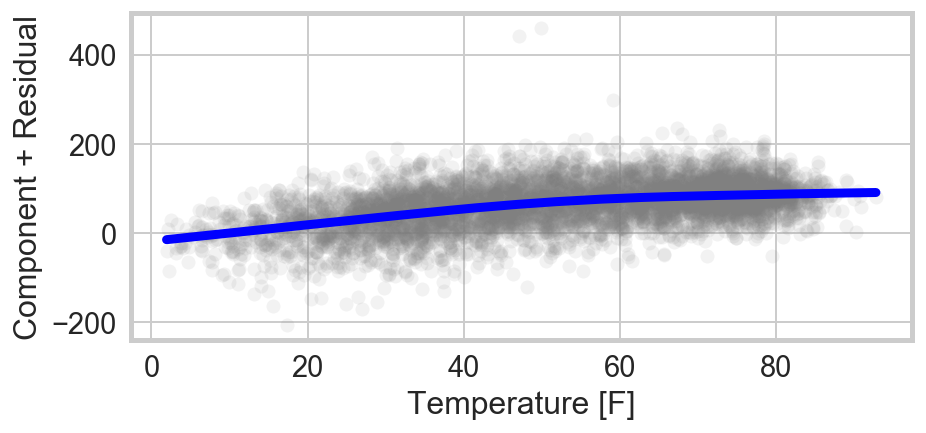

In [50]:
cpr = pd.Series(name = "Component + Residual", data = model.resid + ct_mdw["Temperature [F]"] * model.params["T"])
sns.regplot(x = ct_mdw["Temperature [F]"], y = cpr, lowess = True, 
            scatter_kws = {"alpha" : 0.1, "color" : "grey"}, line_kws = {"color" : "blue"});

We are now fitting the piecewise function,
$$Crime \sim \alpha + \beta_Y Y + \begin{cases}
             \beta_T T  & \text{if } T < T_\text{cut} \\
             \beta_T T_\text{cut} + \beta_{T,\text{high}} (T-T_\text{cut})  & \text{if } T \ge T_\text{cut}
       \end{cases}$$

In [51]:
def residual_kink(vars, T, Y, data):
    
    base   = vars["base"]
    Tcut   = vars["Tcut"]
    betaT  = vars["betaT"]
    betaTh = vars["betaTh"]
    betaY  = vars["betaY"]

    model = base + Y * betaY + np.where(T < Tcut, T * betaT, Tcut*betaT + (T - Tcut) * betaTh) 

    return (data - model) / np.sqrt(data)


params = Parameters()
params.add('betaT', value = 1,  min = 0, max = 10)
params.add('betaTh', value = 0,  min =-3, max = 3)
params.add('betaY', value = -15.6,  min = -50, max = 0)
params.add('Tcut', value = 70,  min = 0, max = 120)
params.add('base', value = 443.2, min = 300, max = 700)

out = minimize(residual_kink, params, 
               args=(ct_mdw["Temperature [F]"], ct_mdw["Year"], ct_mdw["Count"]),
               method = "leastsq")

report_fit(out)

[[Fit Statistics]]
    # function evals   = 96
    # data points      = 5762
    # variables        = 5
    chi-square         = 31918.953
    reduced chi-square = 5.544
    Akaike info crit   = 9874.056
    Bayesian info crit = 9907.351
[[Variables]]
    betaT:    2.00424628 +/- 0.079154 (3.95%) (init= 1)
    betaTh:   0.60483843 +/- 0.082919 (13.71%) (init= 0)
    betaY:   -16.3429905 +/- 0.128233 (0.78%) (init=-15.6)
    Tcut:     49.3341110 +/- 1.650372 (3.35%) (init= 70)
    base:     412.233421 +/- 2.944764 (0.71%) (init= 443.2)
[[Correlations]] (unreported correlations are <  0.100)
    C(betaT, base)               = -0.879 
    C(betaTh, Tcut)              = -0.639 
    C(betaT, Tcut)               = -0.577 
    C(Tcut, base)                =  0.397 
    C(betaY, base)               = -0.390 


The quadratic model has had some problems with convergence, but seems to be working...

In [52]:
params = Parameters()
params.add('betaT', value = 0,  min = -5, max = 5)
params.add('betaY', value = -13.3,  min = -100, max = 0)
params.add('Topt', value = 50,  min = 0,  max = 200)
params.add('base', value = 500, min = 200, max = 700)

def residual_quad(vars, T, Y, data):
    
    base  = vars["base"]
    Topt  = vars["Topt"]
    betaT = vars["betaT"]
    betaY = vars["betaY"]

    model = base + np.power(Topt - T, 2) * betaT + Y * betaY

    return (data - model) / np.sqrt(data)


out = minimize(residual_quad, params, 
               args=(ct_mdw["Temperature [F]"], ct_mdw["Year"], ct_mdw["Count"]),
               method = "leastsq")

report_fit(out)

[[Fit Statistics]]
    # function evals   = 28
    # data points      = 5762
    # variables        = 4
    chi-square         = 31946.112
    reduced chi-square = 5.548
    Akaike info crit   = 9876.957
    Bayesian info crit = 9903.593
[[Variables]]
    betaT:  -0.01782432 +/- 0.001483 (8.32%) (init= 0)
    betaY:  -16.3306502 +/- 0.128320 (0.79%) (init=-13.3)
    Topt:    85.3327534 +/- 3.139738 (3.68%) (init= 50)
    base:    529.231601 +/- 2.169059 (0.41%) (init= 500)
[[Correlations]] (unreported correlations are <  0.100)
    C(betaT, Topt)               =  0.965 
    C(Topt, base)                =  0.754 
    C(betaT, base)               =  0.651 
    C(betaY, base)               = -0.566 
